# Transformer 모델을 이용한 한-영 번역기

## 목차
1. 환경 설정  
2. EDA & 데이터 전처리  
3. 모델 설계  
4. 모델 학습  
5. 시각화 & 결과 해석  
6. Abulation Study & 회고  


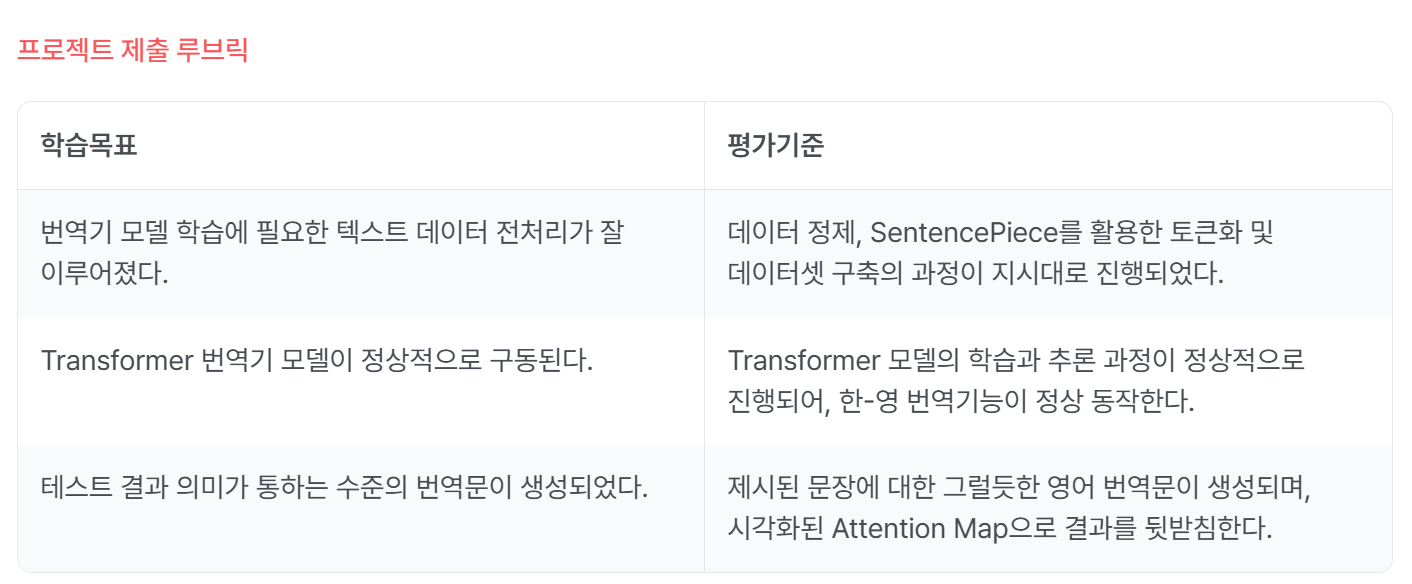

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
%cd "/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD05"

/content/drive/MyDrive/Colab Notebooks/아이펠/AIFFEL_quest_rs/GoingDeeper/GD05


# Definition

## Section 1. 환경 설정

In [80]:
# 기본 라이브러리
import os
import re
import math
import time
import random
from typing import List, Tuple, Dict

# 데이터 처리
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
try:
    from nltk.corpus import wordnet
    wordnet.synsets('test')  # WordNet 사용 가능 여부 확인
except LookupError:
    print("WordNet 다운로드 중...")
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    from nltk.corpus import wordnet

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# SentencePiece
import sentencepiece as spm

# 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc

# 평가
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# 진행바
from tqdm import tqdm

# 설정
from easydict import EasyDict

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# gensim 다운로드
!pip install gensim
from gensim.models import KeyedVectors
import gensim.downloader as api
GENSIM_AVAILABLE = True

# 랜덤 시드 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

2.9.0+cu126


In [ ]:
!sudo apt-get install -y fonts-nanum
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib

# 폰트 등록
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
matplotlib.rc('font', family='NanumGothic')

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

## Section 2. 설정 (configuration)
모델 학습에 필요한 모든 설정을 정의
- 데이터 경로
- 배치 크기
- 에폭 수
- 모델 크기

In [ ]:
# data path
DATA_DIR = './data'
ENG_TRAIN_PATH = f'{DATA_DIR}/korean-english-park.train.en'
KOR_TRAIN_PATH = f'{DATA_DIR}/korean-english-park.train.ko'

# 저장 경로
MODEL_DIR = './models'
TOKENIZER_DIR = './tokenizers'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TOKENIZER_DIR, exist_ok=True)

MODEL_SAVE_PATH = f'{MODEL_DIR}/transformer_eng_kor.pt'
ENG_TOKENIZER_PREFIX = f'{TOKENIZER_DIR}/sp_eng'
KOR_TOKENIZER_PREFIX = f'{TOKENIZER_DIR}/sp_kor'

# data configs
DATA_CONFIG = EasyDict({
    'train_ratio': 0.8,
    'val_ratio': 0.1,
    'test_ratio': 0.1,
    'alpha_sr': 0.1,
    'max_length': 70,     # 최대 시퀀스 길이
    'vocab_size_eng': 8000,
    'vocab_size_kor': 8000,
    'batch_size': 128,    # 배치 크기 (메모리에 맞게 조정)
    'num_workers': 0,     # DataLoader 워커 수
})

# Model config
MODEL_CONFIG = EasyDict({
    'emb_dim': 256,       # 임베딩 차원
    'ffn_dim': 1024,      # Feed-Forward 차원
    'num_heads': 8,       # 어텐션 헤드 수
    'encoder_layers': 6,  # 인코더 레이어 수
    'decoder_layers': 6,  # 디코더 레이어 수
    'dropout': 0.1,
    'attention_dropout': 0.1,
    'max_position_embeddings': 100,
})

# training config
TRAIN_CONFIG = EasyDict({
    'num_epochs': 50,     # 에폭 수 (시간이 오래 걸리면 줄이세요)
    'learning_rate': 0.0005,
    'betas': (0.9, 0.98),
    'eps': 1e-9,
    'weight_decay': 0.01,
    'clip': 1.0,          # 그래디언트 클리핑
    'label_smoothing': 0.1,
    'patience': 5,        # Early Stopping
    'min_delta': 1e-4,
})

print("설정 완료!")
print(f"\n디바이스: {device}")
print(f"배치 크기: {DATA_CONFIG.batch_size}")
print(f"에폭 수: {TRAIN_CONFIG.num_epochs}")
print(f"모델 크기: {MODEL_CONFIG.emb_dim}")

## Section 3. 전처리 함수

In [ ]:
def preprocess_sentence(sentence: str, lang: str = 'kor') -> str:
    """
    문장을 전처리합니다.

    Args:
        sentence: 전처리할 문장
        lang: 언어 타입 ('eng' 또는 'kor')

    Returns:
        전처리된 문장
    """
    sentence = sentence.lower().strip()

    if lang == 'eng':
        sentence = re.sub(r"[^a-zA-Z0-9?.!,']+", " ", sentence)
    else:
        sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 문장부호 앞뒤로 공백 추가
    sentence = re.sub(r'\s+', ' ', sentence) # 연속 공백을 하나의 공백으로 교체
    sentence = sentence.strip()

    return sentence


# def synonym_replacement_augmentation(sentence: str, alpha_sr: float = 0.1) -> str:
#     """
#     Synonym Replacement 기법으로 문장을 증강합니다.

#     적용 기법:
#     - WordNet을 사용하여 단어를 동의어로 교체
#     - 문장 구조와 의미를 최대한 보존

#     Args:
#         sentence: 증강할 문장
#         alpha_sr: 교체할 단어의 비율 (0.0 ~ 1.0)

#     Returns:
#         증강된 문장
#     """
#     from nltk.corpus import wordnet

#     words = sentence.split()
#     num_words = len(words)

#     if num_words <= 1:
#         return sentence

#     # 교체할 단어 수 계산
#     n_replace = max(1, int(alpha_sr * num_words))

#     # 랜덤하게 교체할 단어 인덱스 선택
#     replace_indices = random.sample(range(num_words), min(n_replace, num_words))

#     new_words = words.copy()

#     for idx in replace_indices:
#         word = words[idx]

#         # 구두점이나 특수문자는 건너뛰기
#         if not word.isalnum():
#             continue

#         # WordNet에서 동의어 찾기
#         synonyms = set()
#         for syn in wordnet.synsets(word):
#             for lemma in syn.lemmas():
#                 synonym = lemma.name().replace('_', ' ')
#                 # 원래 단어와 다르고, 단일 단어인 경우만 추가
#                 if synonym.lower() != word.lower() and ' ' not in synonym:
#                     synonyms.add(synonym.lower())

#         # 동의어가 있으면 랜덤하게 선택하여 교체
#         if synonyms:
#             new_words[idx] = random.choice(list(synonyms))

#     return " ".join(new_words)

class LexicalSubstitutor:
    """
    Embedding 기반 Lexical Substitution을 수행하는 클래스

    Word2Vec 또는 GloVe와 같은 사전학습된 단어 임베딩을 활용하여
    의미적으로 유사한 단어로 치환합니다.
    """

    def __init__(self, model_name: str = 'glove-wiki-gigaword-100', use_pretrained: bool = True):
        """
        LexicalSubstitutor 초기화

        Args:
            model_name: 사전학습된 모델 이름
                       추천 모델:
                       - 'glove-wiki-gigaword-100' (권장: 빠르고 가벼움, 약 128MB)
                       - 'glove-wiki-gigaword-200' (균형: 중간 크기, 약 252MB)
                       - 'glove-wiki-gigaword-300' (높은 품질: 약 376MB)
                       - 'word2vec-google-news-300' (최고 품질: 매우 느림, 약 1.6GB)
            use_pretrained: 사전학습된 모델 사용 여부
        """
        if not GENSIM_AVAILABLE:
            raise ImportError(
                "gensim이 필요합니다. 'pip install gensim'으로 설치하세요."
            )

        self.model_name = model_name
        self.model = None

        if use_pretrained:
            print(f"\nloading pretrained embedding: '{model_name}'")

            try:
                self.model = api.load(model_name)
                print(f"  - vocab size: {len(self.model.index_to_key):,} word")
                print(f"  - embedding dim: {self.model.vector_size}D\n")
            except Exception as e:
                print(f"\n failed to load embedding: {e}")

                raise

    def get_similar_words(self, word: str, topn: int = 10) -> List[str]:
        """
        주어진 단어와 의미적으로 유사한 단어들을 반환합니다.

        코사인 유사도를 기반으로 임베딩 공간에서 가장 가까운 단어들을 찾습니다.

        Args:
            word: 대상 단어
            topn: 반환할 유사 단어 개수

        Returns:
            유사한 단어들의 리스트 (유사도 순)
        """
        if self.model is None:
            return []

        try:
            word_lower = word.lower()

            # 단어가 임베딩 어휘에 있는지 확인
            if word_lower not in self.model:
                return []

            # 코사인 유사도 기반 가장 유사한 단어들 가져오기
            similar = self.model.most_similar(word_lower, topn=topn)

            # (단어, 유사도) 튜플 리스트에서 단어만 추출
            similar_words = [w for w, score in similar]

            # 원본 단어와 다른 단어만 반환 (대소문자 무시)
            similar_words = [w for w in similar_words
                           if w.lower() != word_lower]

            return similar_words

        except Exception:
            return []

    def substitute_word(self, word: str, topn: int = 5) -> str:
        """
        단어를 의미적으로 유사한 단어로 치환합니다.

        Args:
            word: 치환할 단어
            topn: 고려할 유사 단어 개수

        Returns:
            치환된 단어 (치환 불가능하면 원본 반환)
        """
        similar_words = self.get_similar_words(word, topn=topn)

        if similar_words:
            # 유사 단어 중 랜덤하게 선택
            substitute = random.choice(similar_words)

            # 원본 단어의 대소문자 패턴 유지
            if word[0].isupper():
                substitute = substitute.capitalize()

            return substitute

        return word  # 치환 실패시 원본 반환


def lexical_substitution_augmentation(
    sentence: str,
    substitutor: LexicalSubstitutor,
    alpha_sr: float = 0.1,
    topn: int = 5
) -> str:
    """
    Embedding 기반 Lexical Substitution으로 문장을 증강합니다.

    적용 기법:
    - Word Embedding (Word2Vec, GloVe 등)을 사용하여 의미적으로 유사한 단어로 치환
    - 코사인 유사도 기반 문맥 고려
    - 대소문자 패턴 유지
    - 구두점 및 특수문자 보존

    예시:
        원본: "i love machine learning"
        증강: "i love machine scholarship"  (learning → scholarship)

    Args:
        sentence: 증강할 문장
        substitutor: LexicalSubstitutor 인스턴스
        alpha_sr: 치환할 단어의 비율 (0.0 ~ 1.0)
        topn: 각 단어에 대해 고려할 유사 단어 개수

    Returns:
        증강된 문장
    """
    words = sentence.split()
    num_words = len(words)

    # 단어가 너무 적으면 증강하지 않음
    if num_words <= 1:
        return sentence

    # 치환할 단어 수 계산
    n_replace = max(1, int(alpha_sr * num_words))

    # 랜덤하게 치환할 단어 인덱스 선택
    replace_indices = random.sample(range(num_words), min(n_replace, num_words))

    new_words = words.copy()

    for idx in replace_indices:
        word = words[idx]

        # 구두점이나 특수문자는 건너뛰기
        if not word.isalnum():
            continue

        # Embedding 기반 유사 단어로 치환
        substitute = substitutor.substitute_word(word, topn=topn)
        new_words[idx] = substitute

    return " ".join(new_words)


def load_data(eng_path: str, kor_path: str):
    """
    영어-한국어 병렬 말뭉치를 로드하고 전처리합니다.
    """
    print("=" * 60)
    print("데이터 로드 및 전처리 시작...")

    with open(eng_path, 'r', encoding='utf-8') as f:
        eng_lines = f.readlines()

    with open(kor_path, 'r', encoding='utf-8') as f:
        kor_lines = f.readlines()

    questions = []
    answers = []
    cleaned_pairs = set()

    for eng, kor in zip(eng_lines, kor_lines):
        clean_eng = preprocess_sentence(eng, lang='eng')
        clean_kor = preprocess_sentence(kor, lang='kor')

        if clean_eng and clean_kor and (clean_eng, clean_kor) not in cleaned_pairs:
            cleaned_pairs.add((clean_eng, clean_kor))
            questions.append(clean_eng)
            answers.append(clean_kor)

    print(f"전체 유효 데이터 쌍: {len(questions):,}")
    print("데이터 로드 완료!")
    print("=" * 60)

    return questions, answers


def augment_train_data(
    train_q: List[str],
    train_a: List[str],
    alpha_sr: float = 0.1,
    model_name: str = 'glove-wiki-gigaword-100',
    topn: int = 5
):
    """
    학습 데이터를 Lexical Substitution 기법으로 증강합니다.

    기존 함수명과 시그니처를 유지하여 호환성을 보장합니다.

    작동 방식:
    1. 사전학습된 단어 임베딩 모델 로드
    2. 각 영어 문장에서 alpha_sr 비율만큼의 단어를 선택
    3. 선택된 단어를 임베딩 공간에서 가장 유사한 단어로 치환
    4. 원본 + 증강된 문장을 모두 학습 데이터에 포함

    Args:
        train_q: 원본 영어 문장 리스트
        train_a: 원본 한국어 번역 리스트
        alpha_sr: 치환 비율 (0.0 ~ 1.0, 기본값 0.1은 10% 단어 치환)
        model_name: 사용할 임베딩 모델 이름
        topn: 각 단어에 대해 고려할 유사 단어 개수

    Returns:
        증강된 (영어 문장, 한국어 번역) 튜플
    """
    print("=" * 60)
    print("Lexical Substitution 기반 데이터 증강")
    print(f"  임베딩 모델: {model_name}")
    print(f"  치환 비율 (alpha): {alpha_sr * 100:.1f}%")
    print(f"  Top-N 유사 단어: {topn}")
    print("=" * 60)

    # LexicalSubstitutor 초기화
    substitutor = LexicalSubstitutor(model_name=model_name)

    aug_q = []
    aug_a = []

    print("증강 진행 중...")

    # tqdm이 있으면 사용, 없으면 일반 루프
    try:
        from tqdm import tqdm
        iterator = tqdm(zip(train_q, train_a), total=len(train_q), desc="  증강 중")
    except ImportError:
        iterator = zip(train_q, train_a)
        print(f"  총 {len(train_q):,}개 문장 처리 중...")

    changed_count = 0

    for q, a in iterator:
        # 원본 추가
        aug_q.append(q)
        aug_a.append(a)

        # 증강된 문장 생성
        new_q = lexical_substitution_augmentation(
            q,
            substitutor,
            alpha_sr=alpha_sr,
            topn=topn
        )

        # 변화가 있으면 추가
        if new_q != q:
            aug_q.append(new_q)
            aug_a.append(a)  # 한국어 번역은 동일하게 유지
            changed_count += 1

    print("\n" + "=" * 60)
    print("데이터 증강 완료!")
    print(f"  증강 전 Train 개수: {len(train_q):,}")
    print(f"  증강 후 Train 개수: {len(aug_q):,}")
    print(f"  증강 비율: {len(aug_q) / len(train_q):.2f}x")
    print(f"  실제 변경된 문장: {changed_count:,} ({changed_count/len(train_q)*100:.1f}%)")
    print("=" * 60)

    return aug_q, aug_a


print("데이터 전처리 함수 정의 완료!")
print("\n사용 가능한 임베딩 모델:")
print("  - 'glove-wiki-gigaword-100' (권장: 빠르고 가벼움)")
print("  - 'glove-wiki-gigaword-200' (균형)")
print("  - 'glove-wiki-gigaword-300' (높은 품질)")
print("  - 'word2vec-google-news-300' (최고 품질, 매우 느림)")

## Section 4. 토크나이저
SentencePiece 토크나이저 정의

In [73]:
def train_sentencepiece(data: List[str], model_prefix: str, vocab_size: int = 8000):
    """
    SentencePiece 모델을 학습합니다.
    """
    print("=" * 60)
    print(f"SentencePiece 학습: {model_prefix} (Vocab: {vocab_size})")

    corpus_path = f'{model_prefix}_corpus.txt'
    with open(corpus_path, 'w', encoding='utf-8') as f:
        for line in data:
            f.write(f'{line}\n')

    train_args = (
        f'--input={corpus_path} '
        f'--model_prefix={model_prefix} '
        f'--vocab_size={vocab_size} '
        f'--model_type=unigram '
        f'--pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 '
        f'--character_coverage=1.0'
    )

    spm.SentencePieceTrainer.Train(train_args)

    if os.path.exists(corpus_path):
        os.remove(corpus_path)

    print(f"완료: {model_prefix}.model")
    print("=" * 60)
    return f"{model_prefix}.model"


class SentencePieceVocab:
    """
    SentencePiece 기반 어휘 사전 클래스
    """

    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(model_path)

        self.PAD_ID = 0
        self.UNK_ID = 1
        self.BOS_ID = 2
        self.EOS_ID = 3

        self.stoi = {'<pad>': 0, '<unk>': 1, '<s>': 2, '</s>': 3}
        self.itos = [self.sp.IdToPiece(i) for i in range(self.sp.GetPieceSize())]

    def encode(self, text: str) -> List[int]:
        return self.sp.EncodeAsIds(text)

    def decode(self, ids: List[int]) -> str:
        filtered_ids = [i for i in ids if i not in [self.PAD_ID, self.BOS_ID, self.EOS_ID]]
        return self.sp.DecodeIds(filtered_ids)

    def __len__(self) -> int:
        return self.sp.GetPieceSize()


print("토크나이저 클래스 정의 완료!")

SentencePiece 모델 학습 완료!


## Section 5. Dataset & DataLoader
번역 작업을 위한 Dataset과 DataLoader를 정의

In [ ]:
class TranslationDataset(Dataset):
    """
    번역 작업을 위한 PyTorch Dataset
    """

    def __init__(self, src_list, trg_list, vocab_src, vocab_trg, max_length=60):
        self.src_list = src_list
        self.trg_list = trg_list
        self.vocab_src = vocab_src
        self.vocab_trg = vocab_trg
        self.max_length = max_length

    def __len__(self):
        return len(self.src_list)

    def __getitem__(self, idx):
        src_text = self.src_list[idx]
        trg_text = self.trg_list[idx]

        src_encoded = [self.vocab_src.BOS_ID] + self.vocab_src.encode(src_text) + [self.vocab_src.EOS_ID]

        trg_encoded = [self.vocab_trg.BOS_ID] + self.vocab_trg.encode(trg_text) + [self.vocab_trg.EOS_ID]

        src_encoded = src_encoded[:self.max_length]
        trg_encoded = trg_encoded[:self.max_length]

        return {
            'SRC': torch.tensor(src_encoded, dtype=torch.long),
            'TRG': torch.tensor(trg_encoded, dtype=torch.long),
            'SRC_TEXT': src_text,
            'TRG_TEXT': trg_text
        }


def collate_fn(batch, pad_idx=0):
    """
    배치 내 샘플들을 동일한 길이로 패딩합니다.
    """
    src_batch = [item['SRC'] for item in batch]
    trg_batch = [item['TRG'] for item in batch]
    src_text = [item['SRC_TEXT'] for item in batch]
    trg_text = [item['TRG_TEXT'] for item in batch]

    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=pad_idx)
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=pad_idx)

    return {
        'SRC': src_padded,
        'TRG': trg_padded,
        'SRC_TEXT': src_text,
        'TRG_TEXT': trg_text
    }


print("Dataset 및 DataLoader 함수 정의 완료!")

## Section 6. 모델
Transformer 모델과 하위 모듈 정의  
- Multi-Head Attention
- Feed-Forward
- Sinusoidal Positional Embedding
- Encoder Layer
- Encoder
- Decoder Layer
- Decoder
- Transformer

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    멀티 헤드 어텐션 (Multi-Head Attention)
    """

    def __init__(self, emb_dim, num_heads, dropout=0.0, bias=False,
                 encoder_decoder_attention=False, causal=False):
        super().__init__()

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = emb_dim // num_heads

        # emb_dim(d_model)은 num_heads로 나누어떨어져야 함
        assert self.head_dim * num_heads == self.emb_dim

        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal

        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads, self.head_dim)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, query, key, attention_mask=None):
        q = self.q_proj(query)

        if self.encoder_decoder_attention:
            k = self.k_proj(key)
            v = self.v_proj(key)
        else:
            k = self.k_proj(query)
            v = self.v_proj(query)

        q = self.transpose_for_scores(q)
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attn_weights = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.head_dim)

        if attention_mask is not None:
            if self.causal:
                attn_weights = attn_weights.masked_fill(
                    attention_mask.unsqueeze(0).unsqueeze(1), float("-inf")
                )
            else:
                attn_weights = attn_weights.masked_fill(
                    attention_mask.unsqueeze(1).unsqueeze(2), float("-inf")
                )

        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = torch.matmul(attn_probs, v)

        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        concat_shape = attn_output.size()[:-2] + (self.emb_dim,)
        attn_output = attn_output.view(*concat_shape)
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


class PositionWiseFeedForward(nn.Module):
    """
    위치별 피드포워드 네트워크
    """

    def __init__(self, emb_dim, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(emb_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, emb_dim)
        self.dropout = dropout
        self.activation = nn.ReLU()

    def forward(self, x):
        # residual = x -> 아래 EncoderLayer에서 잔차 연결을 하므로 여기선 제외한다.
        x = self.activation(self.w_1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.w_2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x #+ residual


class SinusoidalPositionalEmbedding(nn.Embedding):
    """
    사인/코사인 위치 임베딩
    """

    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim)
        self._init_weight(self.weight)

    @staticmethod
    def _init_weight(out):
        n_pos, embed_dim = out.shape
        position_enc = torch.zeros(n_pos, embed_dim)

        for pos in range(n_pos):
            for i in range(0, embed_dim, 2):
                position_enc[pos, i] = math.sin(pos / (10000 ** (i / embed_dim)))
                if i + 1 < embed_dim:
                    position_enc[pos, i + 1] = math.cos(pos / (10000 ** ((i + 1) / embed_dim)))

        out.data.copy_(position_enc)
        out.requires_grad = False

    @torch.no_grad() # 데코레이터(@) 방식은 함수 전체에 적용되게 한다.
    def forward(self, input_ids):
        bsz, seq_len = input_ids.shape[:2]
        positions = torch.arange(seq_len, dtype=torch.long, device=self.weight.device)
        return super().forward(positions)

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.attention_dropout)
        self.ffn = PositionWiseFeedForward(config.emb_dim, config.ffn_dim, config.dropout)
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.dropout = config.dropout

    def forward(self, x, attention_mask=None):
        norm_x = self.norm1(x)
        attn_output, attn_weights = self.self_attn(norm_x, norm_x, attention_mask)
        x = x + F.dropout(attn_output, p=self.dropout, training=self.training) # 여기서 잔차 연결까지 포함

        norm_x = self.norm2(x)
        ffn_output = self.ffn(norm_x)
        x = x + F.dropout(ffn_output, p=self.dropout, training=self.training)

        return x, attn_weights


class Encoder(nn.Module):
    def __init__(self, config, embed_tokens):
        super().__init__()
        self.padding_idx = embed_tokens.padding_idx
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_position_embeddings, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.encoder_layers)])
        self.dropout = nn.Dropout(config.dropout)
        self.final_norm = nn.LayerNorm(config.emb_dim)

    def forward(self, input_ids, attention_mask=None):
        inputs_embeds = self.embed_tokens(input_ids)
        embed_pos = self.embed_positions(input_ids)
        x = self.dropout(inputs_embeds + embed_pos)

        attention_scores = []
        for layer in self.layers:
            x, attn = layer(x, attention_mask)
            attention_scores.append(attn)

        x = self.final_norm(x)
        return x, attention_scores


class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.attention_dropout, causal=True)
        self.cross_attn = MultiHeadAttention(config.emb_dim, config.num_heads, config.attention_dropout, encoder_decoder_attention=True)
        self.ffn = PositionWiseFeedForward(config.emb_dim, config.ffn_dim, config.dropout)
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)
        self.norm3 = nn.LayerNorm(config.emb_dim)
        self.dropout = config.dropout

    def forward(self, x, encoder_output, encoder_attention_mask=None, decoder_causal_mask=None):
        norm_x = self.norm1(x)
        self_attn_output, self_attn_weights = self.self_attn(norm_x, norm_x, decoder_causal_mask)
        x = x + F.dropout(self_attn_output, p=self.dropout, training=self.training)

        norm_x = self.norm2(x)
        cross_attn_output, cross_attn_weights = self.cross_attn(norm_x, encoder_output, encoder_attention_mask)
        x = x + F.dropout(cross_attn_output, p=self.dropout, training=self.training)

        norm_x = self.norm3(x)
        ffn_output = self.ffn(norm_x)
        x = x + F.dropout(ffn_output, p=self.dropout, training=self.training)

        return x, (self_attn_weights, cross_attn_weights)


class Decoder(nn.Module):
    def __init__(self, config, embed_tokens):
        super().__init__()
        self.padding_idx = embed_tokens.padding_idx
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_position_embeddings, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.decoder_layers)])
        self.dropout = nn.Dropout(config.dropout)
        self.final_norm = nn.LayerNorm(config.emb_dim)

    def forward(self, input_ids, encoder_output, encoder_attention_mask=None, decoder_causal_mask=None):
        inputs_embeds = self.embed_tokens(input_ids)
        embed_pos = self.embed_positions(input_ids)
        x = self.dropout(inputs_embeds + embed_pos)

        attention_scores = []
        for layer in self.layers:
            x, attn = layer(x, encoder_output, encoder_attention_mask, decoder_causal_mask)
            attention_scores.append(attn)

        x = self.final_norm(x)
        return x, attention_scores


class Transformer(nn.Module):
    """
    Transformer 모델
    """

    def __init__(self, vocab_src, vocab_trg, config):
        super().__init__()
        self.vocab_src = vocab_src
        self.vocab_trg = vocab_trg
        self.config = config

        self.enc_embedding = nn.Embedding(len(vocab_src), config.emb_dim, padding_idx=vocab_src.PAD_ID)
        self.dec_embedding = nn.Embedding(len(vocab_trg), config.emb_dim, padding_idx=vocab_trg.PAD_ID)

        self.encoder = Encoder(config, self.enc_embedding)
        self.decoder = Decoder(config, self.dec_embedding)
        self.prediction_head = nn.Linear(config.emb_dim, len(vocab_trg))

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_mask(self, src, trg):
        enc_attention_mask = (src == self.vocab_src.PAD_ID)
        tgt_len = trg.size(1)
        dec_causal_mask = torch.triu(
            torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=trg.device), diagonal=1
        )
        return enc_attention_mask, dec_causal_mask

    def forward(self, src, trg):
        enc_attention_mask, dec_causal_mask = self.generate_mask(src, trg)
        encoder_output, encoder_attn = self.encoder(src, enc_attention_mask)
        decoder_output, decoder_attn = self.decoder(trg, encoder_output, enc_attention_mask, dec_causal_mask)
        logits = self.prediction_head(decoder_output)
        return logits, encoder_attn, decoder_attn

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## Section 7. 학습 및 평가 utility

In [ ]:
class LabelSmoothingLoss(nn.Module):
    """
    Label Smoothing을 적용한 Cross Entropy Loss
    """

    def __init__(self, classes, smoothing=0.1, dim=-1, ignore_index=None):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 2))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)

            if self.ignore_index is not None:
                true_dist[:, self.ignore_index] = 0
                mask = torch.nonzero(target.data == self.ignore_index)
                if mask.dim() > 0:
                    true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


def train_epoch(model, iterator, optimizer, criterion, clip, device):
    """
    한 에폭 동안 모델을 학습합니다.
    """
    model.train()
    epoch_loss = 0

    # progress_bar = tqdm(iterator, desc="  Training", leave=False)
    batches = iterator

    for batch in batches :
        src = batch['SRC'].to(device)
        trg = batch['TRG'].to(device)

        optimizer.zero_grad()
        output, _, _ = model(src, trg[:, :-1])

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        # progress_bar.set_postfix(loss=f"{loss.item():.3f}")

    return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion, device):
    """
    모델을 평가
    """
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in iterator:
            src = batch['SRC'].to(device)
            trg = batch['TRG'].to(device)

            output, _, _ = model(src, trg[:, :-1])

            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def translate_sentence(sentence, model, vocab_src, vocab_trg, device, max_len=70):
    """
    하나의 문장을 번역
    """
    model.eval()

    if isinstance(sentence, str):
        tokens = [vocab_src.BOS_ID] + vocab_src.encode(sentence) + [vocab_src.EOS_ID]
    else:
        tokens = [vocab_src.BOS_ID] + vocab_src.encode(sentence) + [vocab_src.EOS_ID]

    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)
    src_mask = (src_tensor == vocab_src.PAD_ID)

    with torch.no_grad():
        encoder_output, _ = model.encoder(src_tensor, src_mask)
        trg_indexes = [vocab_trg.BOS_ID]

        for i in range(max_len):
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            tgt_len = trg_tensor.size(1)
            dec_causal_mask = torch.triu(
                torch.ones(tgt_len, tgt_len, dtype=torch.bool, device=device), diagonal=1
            )

            decoder_output, decoder_attn = model.decoder(
                trg_tensor, encoder_output, src_mask, dec_causal_mask
            )

            pred_token = decoder_output.argmax(2)[:, -1].item()
            trg_indexes.append(pred_token)

            if pred_token == vocab_trg.EOS_ID:
                break

    translated_tokens = [vocab_trg.itos[i] for i in trg_indexes]
    attention = decoder_attn[-1][1].squeeze(0).cpu().detach().numpy()

    return translated_tokens[1:], attention

## Section 7. Attention Map
어텐션을 시각화하는 attention map 함수 정의

In [ ]:
def display_attention(src_tokens, trg_tokens, attention, n_heads=8):
    """
    Attention Map 시각화
    """
    # 토큰 정제
    src_clean = [t.replace('▁', '').replace('<unk>', '?') for t in src_tokens]
    trg_clean = [t.replace('▁', '').replace('<unk>', '?') for t in trg_tokens]

    # 길이 제한
    max_len = 30
    if len(src_clean) > max_len:
        src_clean = src_clean[:max_len]
    if len(trg_clean) > max_len:
        trg_clean = trg_clean[:max_len]

    fig = plt.figure(figsize=(20, 10))

    for i in range(min(n_heads, attention.shape[0])):
        ax = fig.add_subplot(2, 4, i + 1)
        attn = attention[i][:len(trg_clean), :len(src_clean)]

        cax = ax.matshow(attn, cmap='bone')
        ax.tick_params(labelsize=10)

        ax.set_xticks(range(len(src_clean)))
        ax.set_xticklabels(src_clean, rotation=90)
        ax.set_yticks(range(len(trg_clean)))
        ax.set_yticklabels(trg_clean)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.set_title(f'Head {i+1}', fontsize=12)

    plt.tight_layout()
    plt.show()

# Section 3. 데이터 로드

```
kor_path = "./data/korean-english-park.train.ko"
eng_path = "./data/korean-english-park.train.en"

# 데이터 정제
def clean_corpus(kor_path, eng_path):
    """
    1. 한국어 & 영어 corpus 읽기
    2. 병렬 문장 쌍의 개수 검증
    3. 문장쌍을 문자열로 묶음
    4. 중복된 문장쌍 제거
    5. 중복 제거된 corpus 반환
    """
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(["\t".join([k, e]) for k, e in zip(kor, eng)]))

    return cleaned_corpus

data = clean_corpus(kor_path, eng_path)

# Section 4. EDA

총 문장쌍 개수: 78968
예시 3개:
                                                 kor  \
0  한편 피추시킨은 재판이 진행되는 동안 미소를 보이며 경찰을 조롱하는 듯한 발언을 해...   
1  하미드 카르자이 아프간 대통령은 지난 3월 있었던 이탈리아 기자 납치사건 당시 탈레...   
2  트리플 크라운에 도전하는 아스널과 맨유의 대결은 FA 16강전 중 가장 흥미를 끄는...   

                                                 eng  
0  Throughout his trial, Pichushkin gloated over ...  
1  Afghan President Hamid Karzai has previously r...  
2  The last 16 meeting of the top two in the Prem...  
중복된 문장쌍 개수: 0
결측치 및 빈 문장 개수: 0

=== 한국어 문장 길이 통계 ===
최소:    1
최대:    82
평균:    14.72
중앙값:  14.0
95% 분위수: 26.0
99% 분위수: 33.0

=== 영어 문장 길이 통계 ===
최소:    1
최대:    90
평균:    22.15
중앙값:  21.0
95% 분위수: 40.0
99% 분위수: 49.0


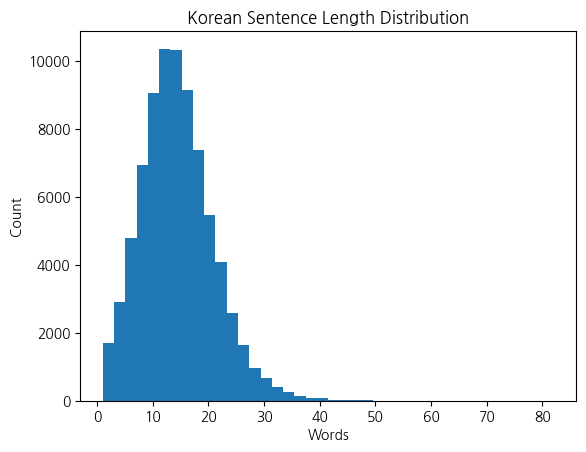

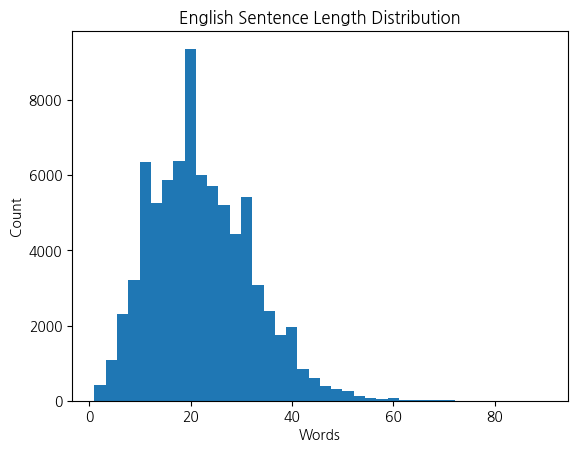

이상치 문장쌍 개수: 661
                     kor                                                eng
120          남한의 객관적 평가?  The South Korean government has consistently p...
139                 그렇죠?                 that are kind of doing us a favor.
191  protesters 항의자, 항변자  The BBC reports up to 80 protesters are report...
249  영한사전 약어표 / 한영사전 약어표  Hit by a series of recent corruption scandals,...
319       under way 진행중에  Counting is under way in Thailand after voting...


In [67]:
# 1. DataFrame 생성 (kor / eng 컬럼)
df = pd.DataFrame([line.split("\t") for line in data], columns=["kor", "eng"])

# 2. 기본 정보 확인
print("="*50)
print(f"총 문장쌍 개수: {len(df)}")
print("예시 3개:")
print(df.head(3))

# 3. 중복 & 결측치 확인
print("="*50)
duplicates = df.duplicated().sum()
missing = df.isnull().sum().sum() + (df["kor"].str.strip() == "").sum() + (df["eng"].str.strip() == "").sum()
print(f"중복된 문장쌍 개수: {duplicates}")
print(f"결측치 및 빈 문장 개수: {missing}")

# 4. 문장 길이 계산 (단어 기준)
df["kor_len"] = df["kor"].apply(lambda x: len(x.split()))
df["eng_len"] = df["eng"].apply(lambda x: len(x.split()))

# 5. 통계 출력 함수
def print_stats(name, lens):
    print(f"\n=== {name} 문장 길이 통계 ===")
    print(f"최소:    {np.min(lens)}")
    print(f"최대:    {np.max(lens)}")
    print(f"평균:    {np.mean(lens):.2f}")
    print(f"중앙값:  {np.median(lens)}")
    print(f"95% 분위수: {np.percentile(lens, 95)}")
    print(f"99% 분위수: {np.percentile(lens, 99)}")

print_stats("한국어", df["kor_len"])
print_stats("영어", df["eng_len"])

# 6. 히스토그램
plt.hist(df["kor_len"], bins=40)
plt.title("Korean Sentence Length Distribution")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

plt.hist(df["eng_len"], bins=40)
plt.title("English Sentence Length Distribution")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

# 7. 이상치 확인 (비율 기준)
df["ratio"] = df["eng_len"] / df["kor_len"].replace(0, np.nan)
outliers = df[(df["ratio"] > 5) | (df["ratio"] < 0.2)]

print("="*50)
print(f"이상치 문장쌍 개수: {len(outliers)}")
print(outliers[["kor", "eng"]].head(5))

### **EDA 결과**
### 1. 중복 & 결측치
데이터는 약 8만 개의 문장 쌍으로 이루어져 있으며, 중복 데이터와 결측치는 없다.

---  
### 2. 이상치
한/영 문장의 길이를 기준으로 이상치를 판별한 결과 661 쌍의 이상치가 발견되었고, 눈으로 봐도 잘못된 번역인 것을 알 수 있다.  
따라서 661개의 이상치는 노이즈로 간주하고 제거하겠다.  

---
### 3. 문장 길이
임시로 공백 기준 토큰화를 한 다음 단어 개수 기준으로 문장 길이를 측정했을 때, 한국어와 영어 모두 최대값과 99% 분위수 사이에 큰 차이가 존재하는 것을 발견했다.  
따라서 SentencePiece 토큰화를 수행한 후, 모델 학습 효율을 위해 극단치는 제거하겠다.

In [68]:
df['kor'] = df['kor'].apply(preprocess_text)
df['eng'] = df['eng'].apply(preprocess_text)

print("\n전처리 후:")
df.head(3)


전처리 후:


,kor,eng,kor_len,eng_len,ratio
0,한편 피추시킨은 재판이 진행되는 동안 미소를 보이며 경찰을 조롱하는 듯한 발언을 해...,"throughout his trial , pichushkin gloated over...",15,15,1.000000
1,하미드 카르자이 아프간 대통령은 지난 3월 있었던 이탈리아 기자 납치사건 당시 탈레...,afghan president hamid karzai has previously r...,19,34,1.789474
2,트리플 크라운에 도전하는 아스널과 맨유의 대결은 fa 16강전 중 가장 흥미를 끄는...,the last 16 meeting of the top two in the prem...,15,34,2.266667


In [69]:
# 이상치 제거

# 1. 문장 길이 계산 (단어 기준)
df["kor_len"] = df["kor"].apply(lambda x: len(x.split()))
df["eng_len"] = df["eng"].apply(lambda x: len(x.split()))

# 2. 길이 비율 계산
df["ratio"] = df["eng_len"] / df["kor_len"].replace(0, np.nan)  # 0 방지

# 3. 이상치 인덱스 확인 (비율 >5 또는 <0.2)
outliers = df[(df["ratio"] > 5) | (df["ratio"] < 0.2)]
print("이상치 문장쌍 개수:", len(outliers))

# 4. 이상치 제거
df_filtered = df[(df["ratio"] <= 5) & (df["ratio"] >= 0.2)].reset_index(drop=True)
print("제거 후 코퍼스 크기:", len(df_filtered))

# 이상치 일부 출력
outliers.head()

이상치 문장쌍 개수: 649
제거 후 코퍼스 크기: 78318


,kor,eng,kor_len,eng_len,ratio
120,남한의 객관적 평가 ?,the south korean government has consistently p...,4,24,6.000000
249,영한사전 약어표 한영사전 약어표,hit by a series of recent corruption scandals ...,4,32,8.000000
319,under way 진행중에,counting is under way in thailand after voting...,3,28,9.333333
329,영어사전,a big crisis of mbc .,1,6,6.000000
349,"normalize 정상화하다 , 표준화하다",the us and north korea have had very good talk...,4,26,6.500000


In [64]:
# 파일 저장
df["eng"].to_csv("./data/eng_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")
df["kor"].to_csv("./data/kor_corpus.txt", index=False, header=False, sep="\n", encoding="utf-8")

print("data 폴더에 저장 완료: eng_corpus.txt, kor_corpus.txt")

data 폴더에 저장 완료: eng_corpus.txt, kor_corpus.txt


In [74]:
# SentencePiece 모델 로드
encoder_tokenizer = spm.SentencePieceProcessor()
encoder_tokenizer.load("encoder_spm.model") # 한국어

decoder_tokenizer = spm.SentencePieceProcessor()
decoder_tokenizer.load("decoder_spm.model") # 영어

True

In [76]:
# 샘플로 인코딩, 디코딩 확인
kor_sample = df["kor"][10000]
eng_sample = df["eng"][10000]
print(kor_sample)
print(eng_sample)

# bos, eos 토큰 추가
enc_token = encoder_tokenizer.encode(kor_sample)
enc_token = [encoder_tokenizer.bos_id()] + enc_token + [encoder_tokenizer.eos_id()]
print("\n인코딩 토큰:", enc_token)

# 위 토큰을 디코딩하면?
enc_decoding = encoder_tokenizer.decode(enc_token)
print("디코딩 토큰:", enc_decoding)

그러나 에드로간 총리는 터키 지도부는 편협하고 급한 영웅주의를 인정하지 않는다 며 즉각적인 월경작전은 없을 것이라 전했다 .
but he also suggested he was not seeking an immediate cross border offensive against the rebels of the kurdistan workers' party , or pkk , holed up in bases in northern iraq . the responsibility of leadership does not allow for narrow mindedness , haste or heroism , he said .

인코딩 토큰: [1, 4, 95, 3903, 18, 198, 136, 8, 837, 3181, 8, 1373, 7991, 34, 2509, 17, 4908, 1215, 11, 1023, 102, 737, 77, 4212, 19, 4, 54, 418, 4721, 10, 1760, 1545, 58, 5, 2]
디코딩 토큰: 그러나 에드로간 총리는 터키 지도부는 편협하고 급한 영웅주의를 인정하지 않는다 며 즉각적인 월경작전은 없을 것이라 전했다 .


한국어 최대 길이: 160
영어 최대 길이: 118
한국어 평균 길이: 29.92
영어 평균 길이: 30.75
------------------------------
상위 90% 길이 -> 한국어: 47 | 영어: 49
상위 95% 길이 -> 한국어: 53 | 영어: 55
상위 99% 길이 -> 한국어: 67 | 영어: 68
상위 99.9% 길이 -> 한국어: 89 | 영어: 86


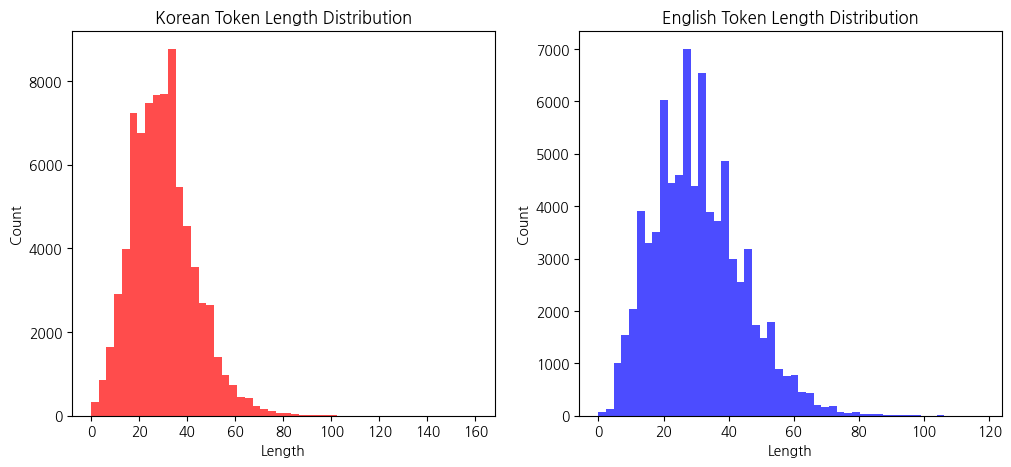

In [77]:
# 토큰화 후 데이터 분포 확인

# df_copy 전처리
df_copy = df.copy()
df_copy["kor"] = df_copy["kor"].apply(preprocess_text)
df_copy["eng"] = df_copy["eng"].apply(preprocess_text)

# 2. 전체 데이터 토큰화 및 길이 계산
# encode_as_ids: 텍스트를 정수 시퀀스로 변환
df_copy['kor_sp_ids'] = df_copy['kor'].apply(lambda x: encoder_tokenizer.encode_as_ids(str(x)))
df_copy['eng_sp_ids'] = df_copy['eng'].apply(lambda x: decoder_tokenizer.encode_as_ids(str(x)))

# 길이 계산
df_copy['kor_sp_len'] = df_copy['kor_sp_ids'].apply(len)
df_copy['eng_sp_len'] = df_copy['eng_sp_ids'].apply(len)

# 3. 통계 정보 출력
print(f"한국어 최대 길이: {df_copy['kor_sp_len'].max()}")
print(f"영어 최대 길이: {df_copy['eng_sp_len'].max()}")
print(f"한국어 평균 길이: {df_copy['kor_sp_len'].mean():.2f}")
print(f"영어 평균 길이: {df_copy['eng_sp_len'].mean():.2f}")

# 4. 백분위수(Percentile) 확인
print("-" * 30)
for per in [90, 95, 99, 99.9]:
    kor_len = np.percentile(df_copy['kor_sp_len'], per)
    eng_len = np.percentile(df_copy['eng_sp_len'], per)
    print(f"상위 {per}% 길이 -> 한국어: {int(kor_len)} | 영어: {int(eng_len)}")

# 5. 시각화 (히스토그램)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_copy['kor_sp_len'], bins=50, alpha=0.7, color='red')
plt.title('Korean Token Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(df_copy['eng_sp_len'], bins=50, alpha=0.7, color='blue')
plt.title('English Token Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')

plt.show()

bos, eos 토큰을 포함해서 max_length = 70 정도만 해도 상위 99%는 커버할 수 있다.  
따라서 최대 길이는 70으로 지정한다.

# Section 6. 데이터로더 생성

In [81]:
class TranslationDataset(Dataset):
    def __init__(self, data, encoder_tokenizer, decoder_tokenizer, max_len):
        self.data = data
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer
        self.max_len = max_len
        self.pad_id = encoder_tokenizer.pad_id()
        self.bos_id = encoder_tokenizer.bos_id()
        self.eos_id = encoder_tokenizer.eos_id()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 데이터 로드 (혹시 모를 비문자열 방지를 위해 str 변환)
        src_text = str(self.data.iloc[idx]['kor'])
        trg_text = str(self.data.iloc[idx]['eng'])

        # 1. 토큰화 (IDs로 변환)
        src_ids = self.encoder_tokenizer.encode_as_ids(src_text)
        trg_ids = self.decoder_tokenizer.encode_as_ids(trg_text)

        # 2. 최대 길이 제한 (Special Token 공간 확보를 위해 미리 자름)
        # Encoder: [Text] + [EOS] -> 1개 공간 필요
        # Decoder: [SOS] + [Text] + [EOS] -> 2개 공간 필요 (하지만 입/출력을 쪼개므로 각각 1개씩)

        if len(src_ids) > self.max_len - 1:
            src_ids = src_ids[:self.max_len - 1]

        if len(trg_ids) > self.max_len - 2: # SOS, EOS 고려해서 -2
            trg_ids = trg_ids[:self.max_len - 2]

        # 3. Special Token 추가
        # Encoder 입력에도 EOS 추가
        enc_input = src_ids + [self.eos_id]

        # Decoder Input(SOS시작) vs Label(EOS끝) 분리
        dec_input = [self.bos_id] + trg_ids
        dec_label = trg_ids + [self.eos_id]

        # 4. Padding
        # Encoder Padding
        enc_padding_len = self.max_len - len(enc_input)
        if enc_padding_len > 0:
            enc_input = enc_input + [self.pad_id] * enc_padding_len

        # Decoder Padding (Input과 Label 길이를 동일하게 맞춰야 함)
        dec_padding_len = self.max_len - len(dec_input)
        if dec_padding_len > 0:
            dec_input = dec_input + [self.pad_id] * dec_padding_len
            dec_label = dec_label + [self.pad_id] * dec_padding_len

        # 5. 텐서 변환 (LongTensor가 정수형 인덱스에 적합, 가독성)
        return {
            'src': torch.tensor(enc_input, dtype=torch.long),
            'trg_input': torch.tensor(dec_input, dtype=torch.long),
            'trg_label': torch.tensor(dec_label, dtype=torch.long)
        }

In [82]:
train_ratio = 0.8
MAX_LEN = 70
BATCH_SIZE = 128

train_data = df.sample(frac=train_ratio, random_state=42)
valid_data = df.drop(train_data.index)

train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

train_data = TranslationDataset(train_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)
validataion_data = TranslationDataset(valid_data, encoder_tokenizer, decoder_tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validataion_data, batch_size=BATCH_SIZE, shuffle=False)

In [83]:
# Shape 확인
for batch in train_loader:
    src = batch['src']
    trg_input = batch['trg_input']
    trg_label = batch['trg_label']

    print(f"Src Shape: {src.shape}")
    print(f"Trg Input Shape: {trg_input.shape}")
    print(f"Trg Label Shape: {trg_label.shape}")
    break

Src Shape: torch.Size([128, 70])
Trg Input Shape: torch.Size([128, 70])
Trg Label Shape: torch.Size([128, 70])


# Section 7. Transformer 모델 정의

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    멀티 헤드 어텐션 (Multi-Head Attention)
    """

    def __init__(self, emb_dim, num_heads, dropout=0.0, bias=False,
                 encoder_decoder_attention=False, causal=False):
        super().__init__()

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = emb_dim // num_heads

        # emb_dim(d_model)은 num_heads로 나누어떨어져야 함
        assert self.head_dim * num_heads == self.emb_dim

        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal

        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_heads, self.head_dim)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, query, key, attention_mask=None):
        q = self.q_proj(query)

        if self.encoder_decoder_attention:
            k = self.k_proj(key)
            v = self.v_proj(key)
        else:
            k = self.k_proj(query)
            v = self.v_proj(query)

        q = self.transpose_for_scores(q)
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attn_weights = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(self.head_dim)

        if attention_mask is not None:
            if self.causal:
                attn_weights = attn_weights.masked_fill(
                    attention_mask.unsqueeze(0).unsqueeze(1), float("-inf")
                )
            else:
                attn_weights = attn_weights.masked_fill(
                    attention_mask.unsqueeze(1).unsqueeze(2), float("-inf")
                )

        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = torch.matmul(attn_probs, v)

        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        concat_shape = attn_output.size()[:-2] + (self.emb_dim,)
        attn_output = attn_output.view(*concat_shape)
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


class PositionWiseFeedForward(nn.Module):
    """
    위치별 피드포워드 네트워크
    """

    def __init__(self, emb_dim, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(emb_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, emb_dim)
        self.dropout = dropout
        self.activation = nn.ReLU()

    def forward(self, x):
        # residual = x
        x = self.activation(self.w_1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.w_2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x #+ residual


class SinusoidalPositionalEmbedding(nn.Embedding):
    """
    사인/코사인 위치 임베딩
    """

    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim)
        self._init_weight(self.weight)

    @staticmethod
    def _init_weight(out):
        n_pos, embed_dim = out.shape
        position_enc = torch.zeros(n_pos, embed_dim)

        for pos in range(n_pos):
            for i in range(0, embed_dim, 2):
                position_enc[pos, i] = math.sin(pos / (10000 ** (i / embed_dim)))
                if i + 1 < embed_dim:
                    position_enc[pos, i + 1] = math.cos(pos / (10000 ** ((i + 1) / embed_dim)))

        out.data.copy_(position_enc)
        out.requires_grad = False

    @torch.no_grad()
    def forward(self, input_ids):
        bsz, seq_len = input_ids.shape[:2]
        positions = torch.arange(seq_len, dtype=torch.long, device=self.weight.device)
        return super().forward(positions)

In [4]:
import torch
import numpy as np

def generate_padding_mask(seq):
    mask = (seq == 0).float()
    return mask.unsqueeze(1).unsqueeze(2)

def generate_causality_mask(size):
    """Causal Mask 생성 (Upper triangular matrix)"""
    mask = torch.triu(torch.ones(size, size), diagonal=1)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(tgt)
    seq_len = tgt.shape[-1]
    causal_mask = generate_causality_mask(seq_len)
    batch_size = src.shape[0]
    dec_mask = causal_mask.expand(batch_size, 1, seq_len, seq_len)

    return enc_mask, dec_enc_mask, dec_mask

슝=3


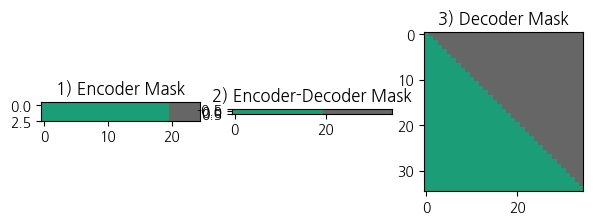

In [5]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = torch.zeros((batch, src_padding))
tgt_pad = torch.zeros((batch, tgt_padding))

sample_data = torch.ones((batch, length))
sample_src = torch.cat([sample_data, src_pad], dim=-1)
sample_tgt = torch.cat([sample_data, tgt_pad], dim=-1)

enc_mask, dec_enc_mask, dec_mask = generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [ ]:
class LearningRateScheduler:
    def __init__(self, d_model, warmup_steps=4000):
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = torch.tensor(step, dtype=torch.float32)
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * torch.minimum(arg1, arg2)

model = nn.Linear(10, 10)
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-9,
    betas=(0.9, 0.98),
    eps=1e-9)